# Google Landmark Detection 

## References

- Weyand, T., Araujo, A., Cao, B., & Sim, J. (2020).  
  *Google Landmarks Dataset v2 – A Large-Scale Benchmark for Instance-Level Recognition and Retrieval.*  
  In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR).  

- Tolias, G., Jégou, H., & Vedaldi, A. (2019).  
  *Detect-to-Retrieve: Efficient Regional Aggregation for Image Search.*  
  In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (CVPR).  


## 1. Importing Libraries 

In [30]:
# Importing Libs
import os 
import cv2 
import random 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
from PIL import Image 

In [32]:
# Model Utils
import keras 
from keras.layers import * 
from keras import Sequential 
from keras.applications.vgg19 import VGG19
tf.compat.v1.disable_eager_execution()
from sklearn.preprocessing import LabelEncoder

## 2. Loading Dataset

In [3]:
# Dataset
df = pd.read_csv("../train.csv")

In [4]:
# Images
base_path = "../images/"

In [5]:
# dataset preview 
df.head()

,id,landmark_id
0,17660ef415d37059,1
1,92b6290d571448f6,1
2,cd41bf948edc0340,1
3,fb09f1e98c6d2f70,1
4,25c9dfc7ea69838d,7


In [6]:
# dataset preview 
df.tail()

,id,landmark_id
1580465,72c3b1c367e3d559,203092
1580466,7a6a2d9ea92684a6,203092
1580467,9401fad4c497e1f9,203092
1580468,aacc960c9a228b5f,203092
1580469,d9e338c530dca106,203092


In [7]:
# dataset info : including memory info  
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1580470 entries, 0 to 1580469
Data columns (total 2 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   id           1580470 non-null  object
 1   landmark_id  1580470 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 110.0 MB


In [8]:
# Taking out the images with starting 00_______.jpg
df  = df.loc[df["id"].str.startswith("00" , na = False)]
n_unique_classes = len(df["landmark_id"].unique()) #  unique number of data 
n_data  = len(df) # no.of data 

In [9]:
n_unique_classes

5346

In [10]:
n_data

6120

In [11]:
data = pd.DataFrame(df["landmark_id"].value_counts()).reset_index()

# Starting
data.head()

,landmark_id,count
0,138982,31
1,83144,14
2,194914,7
3,126637,7
4,9673,6


In [12]:
# Ending
data.tail()

,landmark_id,count
5341,202886,1
5342,202939,1
5343,202950,1
5344,202972,1
5345,202981,1


In [13]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
landmark_id,5346.0,101742.002806,58868.187951,27.0,49712.5,101112.5,153584.75,202981.0
count,5346.0,1.144781,0.641260,1.0,1.0,1.0,1.00,31.0


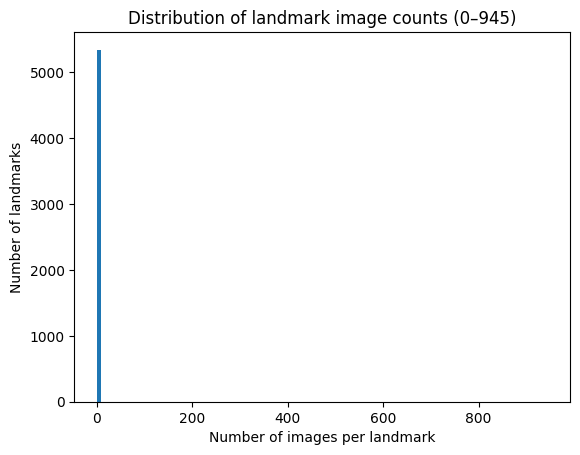

In [14]:
# Visual distribution of sample
plt.hist(data["count"] , 100  , range = (0 , 945))
plt.xlabel("Number of images per landmark")
plt.ylabel("Number of landmarks")
plt.title("Distribution of landmark image counts (0–945)")
plt.show()

In [15]:
data["count"].between(0 , 5).sum()

np.int64(5339)

In [16]:
data["count"].between(5 , 10).sum()

np.int64(14)

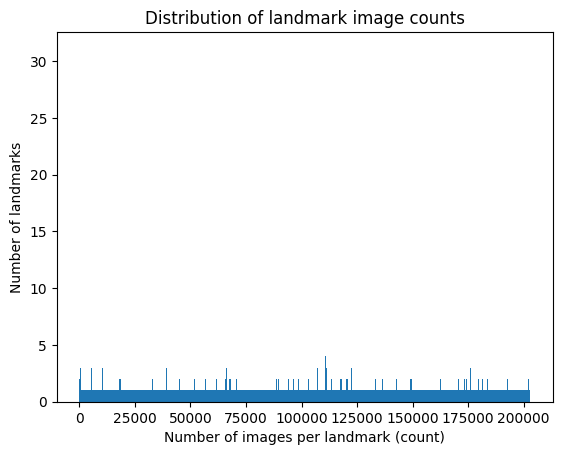

In [17]:
plt.hist(df["landmark_id"], bins=df["landmark_id"].unique())
plt.xlabel("Number of images per landmark (count)")
plt.ylabel("Number of landmarks")
plt.title("Distribution of landmark image counts")
plt.show()

## 3. Preprocessing Data

In [18]:
lbl_encoder = LabelEncoder() 

lbl_encoder.fit(df["landmark_id"])

LabelEncoder()

In [19]:
df.head()

,id,landmark_id
119,00cba0067c078490,27
120,00f928e383e1d121,27
796,009ecdb56b5e9adb,60
1089,00d5d47528839144,124
1133,00e9003a381ab809,134


In [20]:
# Preview of encoded classes 
lbl_encoder.classes_

array([    27,     60,    124, ..., 202950, 202972, 202981])

In [21]:
# Encoder
def encode_label(lbl):
    return lbl_encoder.transform(lbl)

In [22]:
# Decoder
def decode_label(lbl):
    return lbl_encoder.inverse_transform(lbl)

In [23]:
# Get image 
def get_image_from_number(num):
    fname , label = df.loc[num , : ]
    fname = fname + ".jpg"
    # Entering folders
    # can be 0/0/0 ,0/0/1 etc...  
    f1 = fname[0] 
    f2 = fname[1]
    f3 = fname[2]
    path = os.path.join(f1 , f2 , f3 , fname)
    image = cv2.imread(os.path.join(base_path , path)) # Image render
    return image , label

4 Sample images from random classes


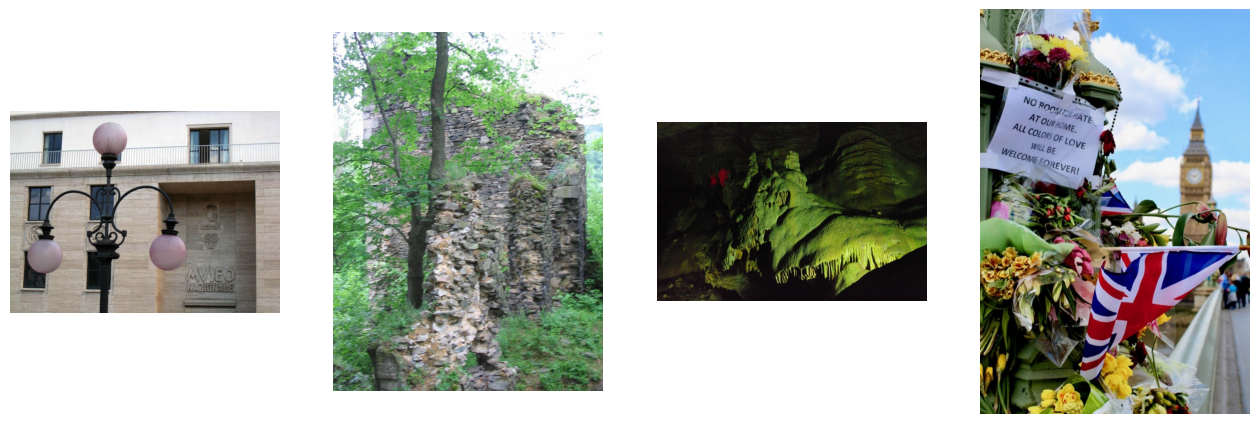

In [24]:
# Preview of images 
print("4 Sample images from random classes")
fig  = plt.figure(figsize = (16 , 16))

for i in range(1 , 5): 
    rf = random.choices(os.listdir(base_path) , k = 3) # random images folder
    folder = base_path + "/" + rf[0] + "/" + rf[1] + "/" + rf[2]
    random_image = random.choice(os.listdir(folder))
    img  = np.array(Image.open(folder + "/" + random_image))
    fig.add_subplot(1, 4, i)
    plt.imshow(img)
    plt.axis("off")

plt.show()

## 4. Model Building  

In [33]:
# Parameter 
learning_rate = 0.0001
decay_speed = 1e-6
momentum = 0.09 
loss_function = "sparse_categorical_crossentropy"
source_mode = VGG19(weights=None)
drop_layer = Dropout(0.5)
drop_layer = Dropout(0.5)